# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

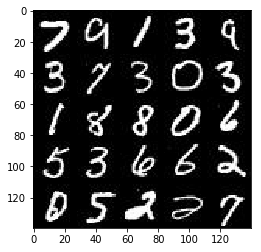

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

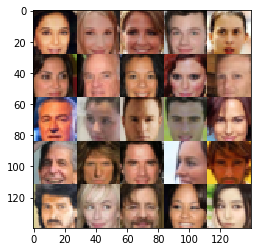

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_height , image_width , image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))  
    learning_rate = tf.placeholder(tf.float32)  
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """   
    alpha = 0.2
    dropout = 0.8
    
    # kernel initializer
    #kerinit = tf.random_normal_initializer(stddev=0.02)
    kerinit = tf.contrib.layers.xavier_initializer(uniform = False)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kerinit, padding='same')        
        x1 = tf.maximum(alpha * x1, x1)        
        x1 = tf.nn.dropout(x1, dropout)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, kernel_initializer=kerinit, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)        
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, dropout)
        
        # 7x7x128   
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, kernel_initializer=kerinit, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=True)        
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, dropout)
        
        # 4x4x256 

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """            
    alpha = 0.2 
    dropout = 0.5
    
    # kernel initializer
    #kerinit = tf.random_normal_initializer(stddev=0.02)
    kerinit = tf.contrib.layers.xavier_initializer(uniform = False)
    
    with tf.variable_scope("generator", reuse = not is_train):
               
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)                        
        x1 = tf.maximum(alpha * x1, x1)           
        x1 = tf.nn.dropout(x1, dropout)
        
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2,  kernel_initializer=kerinit, padding='same')
        # 7x7x128 now
        x2 = tf.layers.batch_normalization(x2, training=is_train)        
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, dropout)
        

        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2,  kernel_initializer=kerinit, padding='same')
        # 14x14x64 now
        #x3 = tf.layers.batch_normalization(x3, training=is_train)        
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, dropout)
        
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1,  kernel_initializer=kerinit, padding='same')
        # 28x28x32 now
        #x4 = tf.layers.batch_normalization(x4, training=is_train)        
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, dropout)
          
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim , 5, strides=1,  kernel_initializer=kerinit, padding='same')
        # 28x28xout_channel_dim now     
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
      
    tf.reset_default_graph()
       
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)        
    
    steps = 0
    print_every= 10
    show_every= 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # train twice generator for faster loss reduction 
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))                    

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1044... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.6935... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.8831... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.7431... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.6360... Generator Loss: 1.0372
Epoch 1/2... Discriminator Loss: 1.7150... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.6131... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.6779... Generator Loss: 0.8114


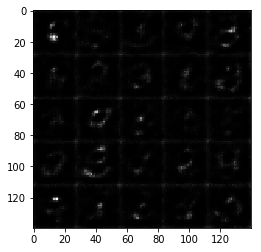

Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 1.2453
Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 0.9480


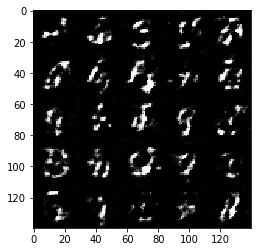

Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 1.0455
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 1.0949
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.9140


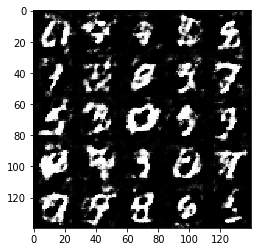

Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 1.1657... Generator Loss: 0.9552
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.0787
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.7767


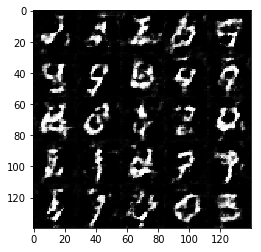

Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 1.3695
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 1.1584


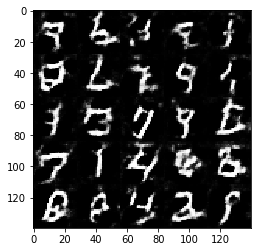

Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 1.4891
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.3789
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 1.5434
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.7978


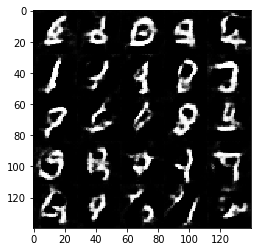

Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 1.0259
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 1.0519


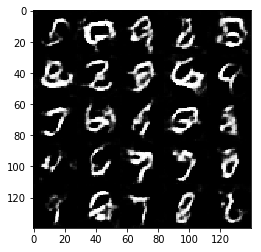

Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.9353
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 1.0292


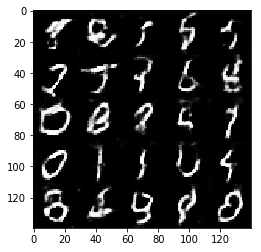

Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.9662
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 1.1411
Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 1.0187
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.8163


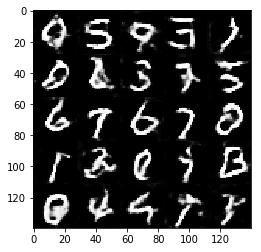

Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.8742
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.7174


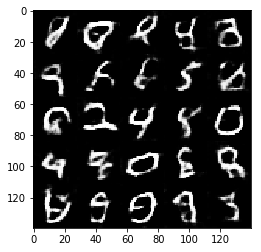

Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 1.0761
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 1.0600
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.9582


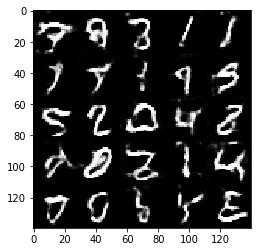

Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.9193


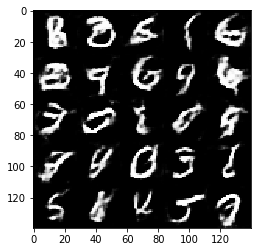

Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.9836
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 1.2208


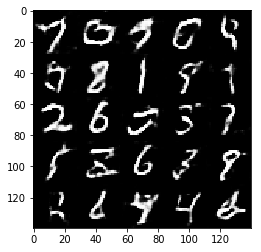

Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.9930
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.9495
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 1.2859


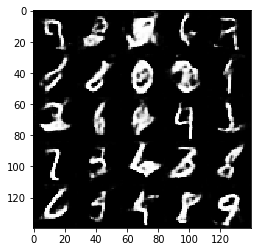

Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.4219
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 1.0234
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.9201


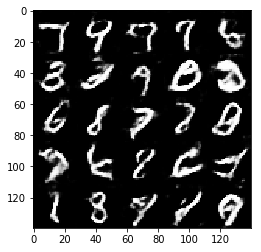

Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 1.0419
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.8796
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 1.1057
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.9908


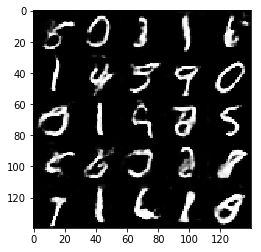

Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 1.1198
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 1.1330
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.8277


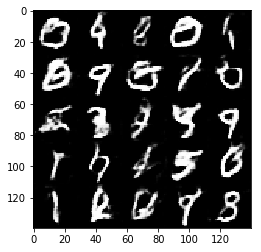

Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.9886
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 1.5272
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.9337


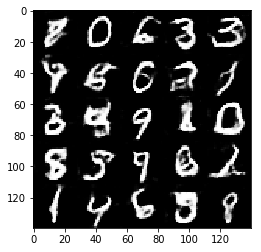

Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 1.2242
Epoch 1/2... Discriminator Loss: 1.4970... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.0985... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 1.0991
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 1.0275


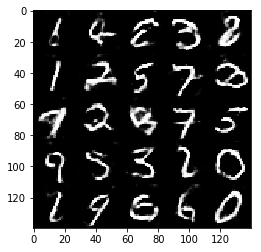

Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 1.1292
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 1.0557
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 1.2130
Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.8470


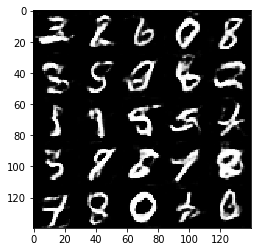

Epoch 2/2... Discriminator Loss: 1.5046... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 1.0346
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 1.2405
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 1.1097
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 1.0506


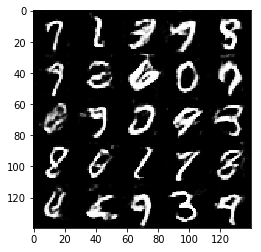

Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.5120... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 1.1780


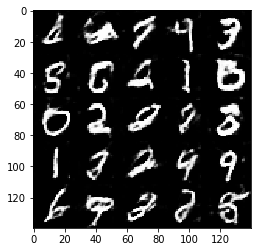

Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.9498
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 1.2622
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.8791


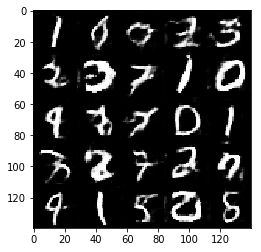

Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.9606
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.9166
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 1.0676
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.8510


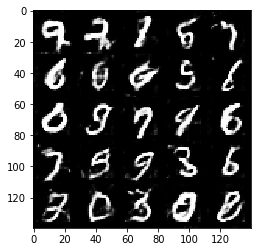

Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.9682
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 1.0024
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.8501


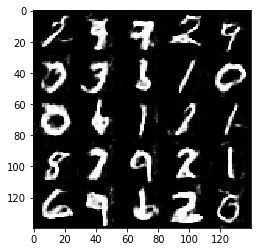

Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 1.1618
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 1.1122
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 1.5235
Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 1.0407


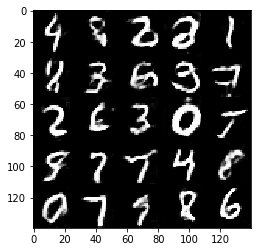

Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.9368
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 1.1820
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.1233


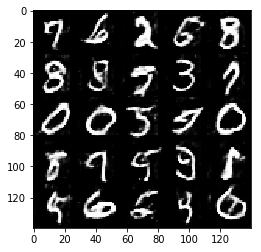

Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.1918... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 1.0482


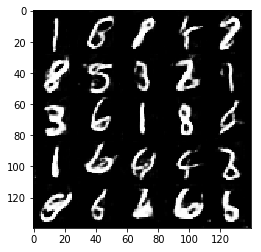

Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.9846
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 1.2174... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.9602


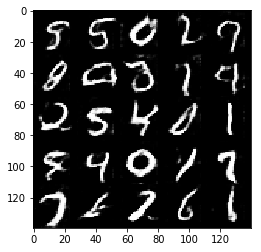

Epoch 2/2... Discriminator Loss: 1.4904... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 1.0707
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 1.1109
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.9312
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.6436


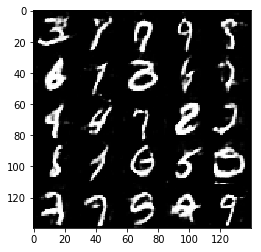

Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 1.2508
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 1.2545
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 1.2336
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 1.0072


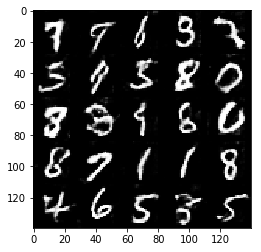

Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 1.4619
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 1.1018
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.9853


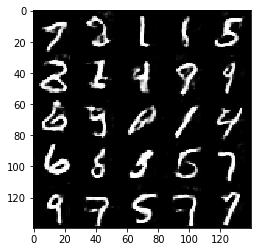

Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 1.0916
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 1.2863
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 1.0575
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 1.2933


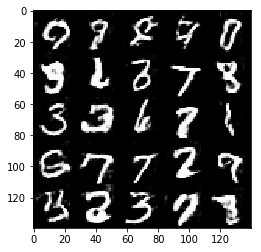

Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 1.1029
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.6870
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 1.4296
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.1271
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 1.2704


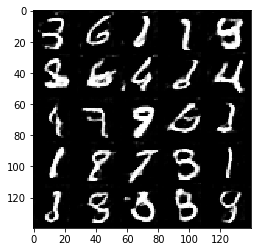

Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.2765
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 1.0194


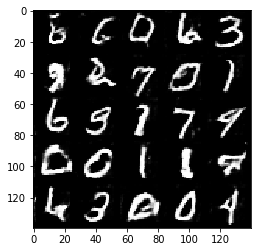

Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.1624
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 1.2554
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 1.1486
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 1.3368
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 1.1262
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 1.2798
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.7908


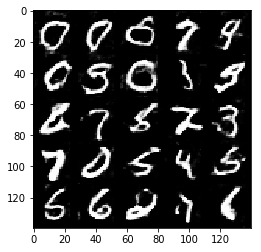

Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.2217
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.0241... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 1.4282
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 1.1461


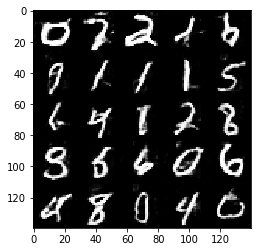

Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 1.2804
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.1531


IndexError: list index out of range

In [15]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6198... Generator Loss: 2.5221
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 2.5213
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.7215
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.6866
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 2.1035
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.2326


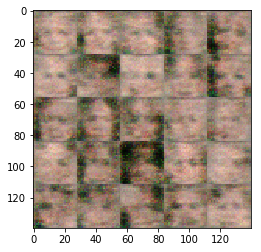

Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 2.1213
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.7491
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.6317
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 1.5993


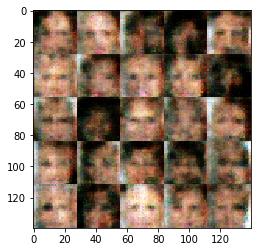

Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.5590
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 2.5869
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.7457
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.5885
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.7282


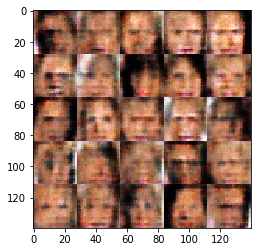

Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.4904
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.6147
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.4299
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.2545


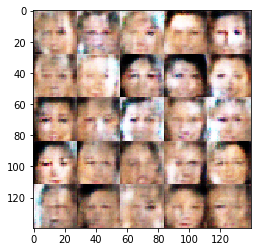

Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.4254
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.3379
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.4471


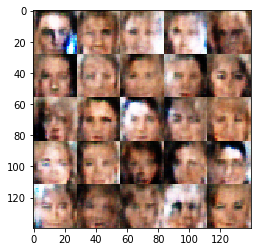

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.4147
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.1283


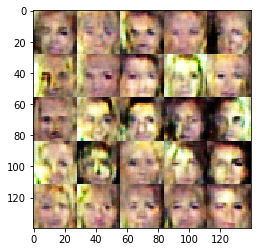

Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.5848
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.3152
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.0726


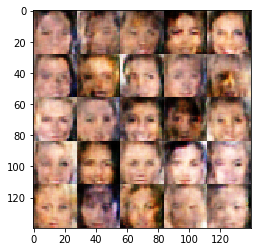

Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.1305


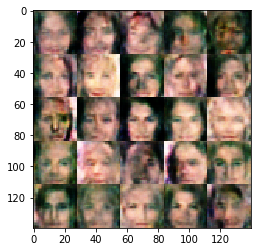

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.2786


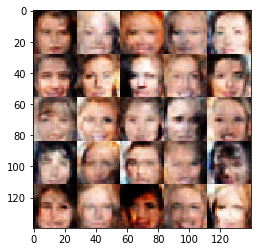

Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.0847


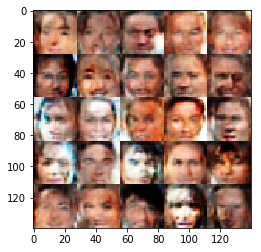

Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 1.1200


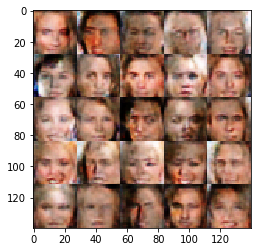

Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.3851


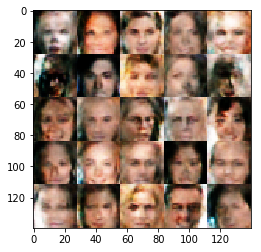

Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.0154


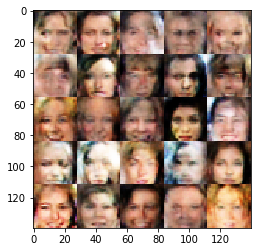

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9996


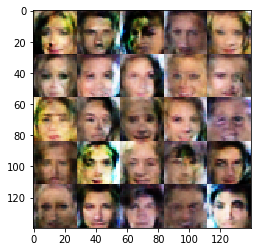

Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9912


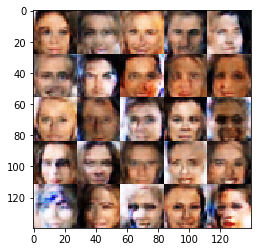

Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.1880
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.1824


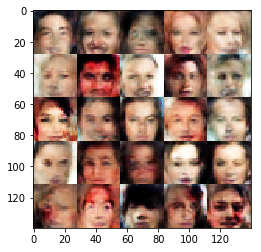

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.0980


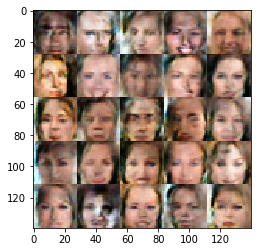

Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.0804


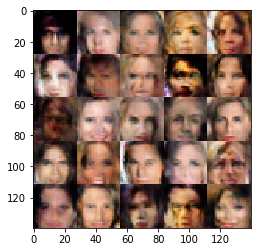

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.9210


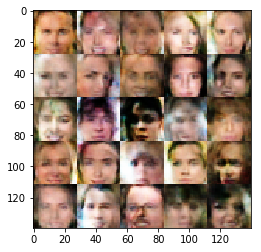

Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.9648


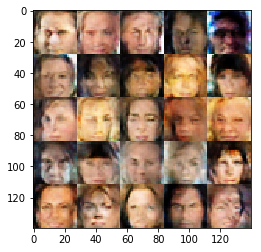

Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.0351


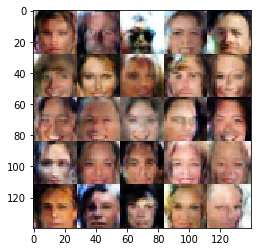

Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9148


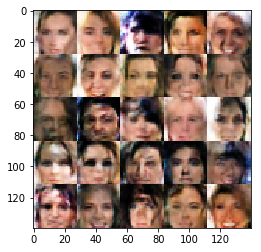

Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.0225


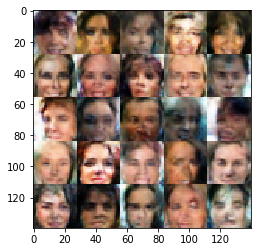

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.9379


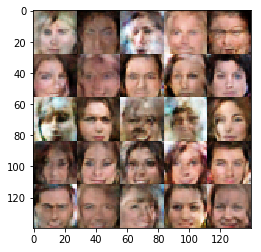

Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.1062


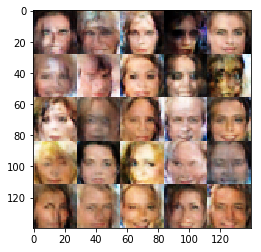

Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.0157


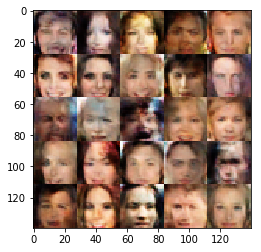

Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.0775


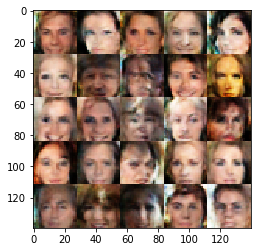

Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.0145


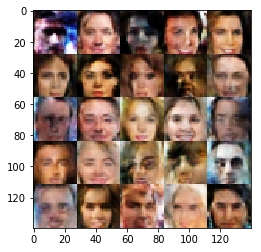

Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.2438


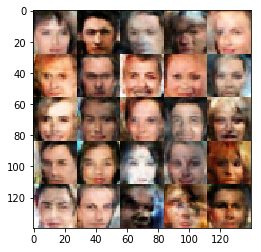

Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9339


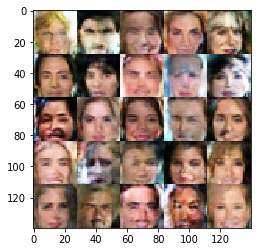

Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.1611
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 1.0977


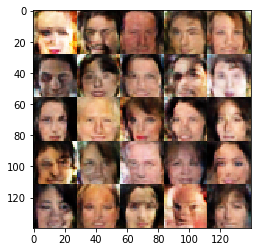

Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.0076


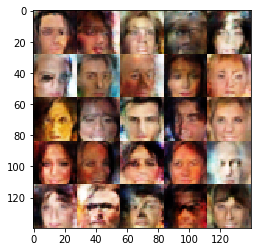

Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.1094


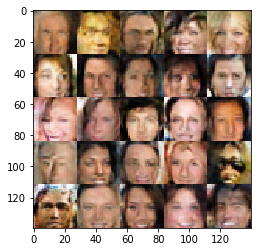

Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.0739


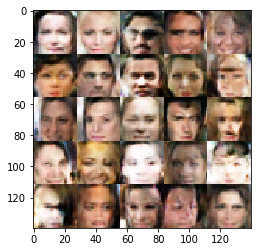

Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8940


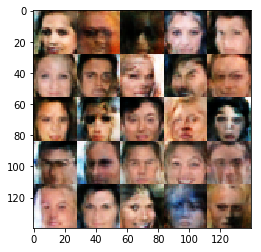

Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8901


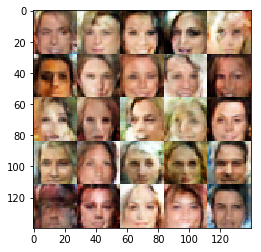

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0808


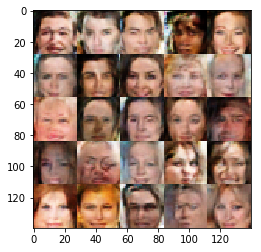

Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.9539


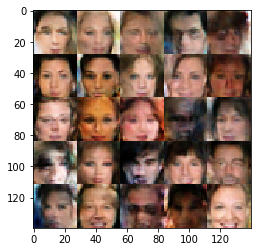

Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.8560


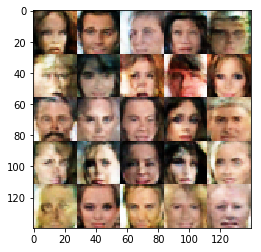

Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8765


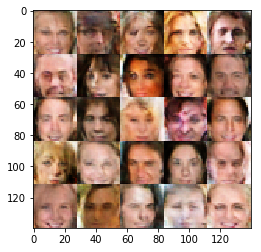

Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.9746


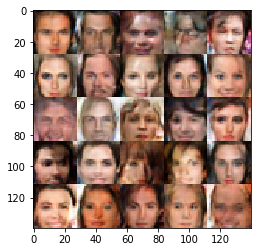

Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.9987


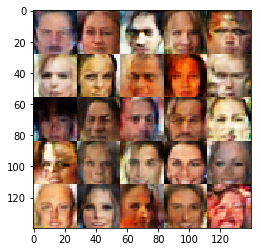

Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.1568


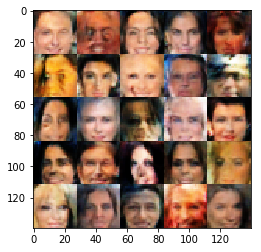

IndexError: list index out of range

In [12]:
batch_size = 48
z_dim = 100
learning_rate = 0.00015
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.